In [1]:
import torch
from scipy.special import expit
import matplotlib.pyplot as plt
from ipywidgets import AppLayout, IntSlider

from scheduling import Schedule, ConstSched, LinSched, CosSched
%matplotlib widget

## Exponential Moving Average /w scheduled momentum
### Toy setting which is close to MNIST witch batchsize 256

In [2]:
DATA_SIZE = 40000
BATCH_SIZE = 200
IT_PER_EPOCH = DATA_SIZE // BATCH_SIZE
EPOCHS = 50
STEPS = EPOCHS*IT_PER_EPOCH

EPOCHS, IT_PER_EPOCH, STEPS

(50, 200, 10000)

### Choice of Momentum Scheduler

torch.Size([10000])

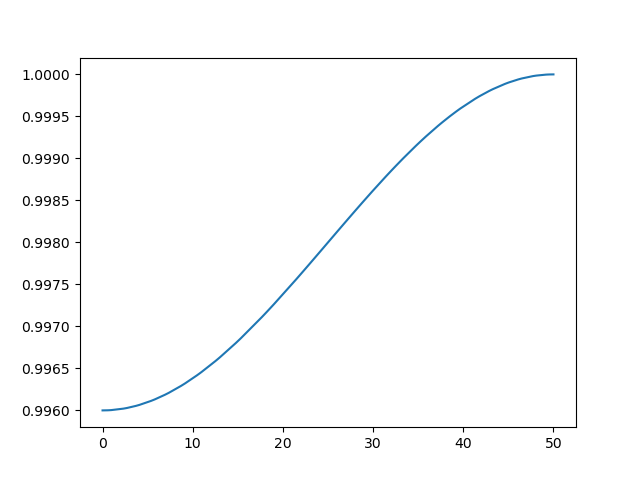

In [3]:
class CosSched(Schedule):
    def __init__(self, y_start, y_end):
        super().__init__()
        self.y_start = y_start
        self.y_end = y_end

    def set_ys(self):
        cos = 0.5 + torch.cos(self.xs(-torch.pi,0)) / 2
        self.ys = self.y_start + (self.y_end - self.y_start) * cos

plt.ion()
plt.figure()

#tmom = ConstSched(0.9998, IT_PER_EPOCH, EPOCHS)
tmom = CosSched(0.996, 1.0).prep(STEPS, EPOCHS)
plt.plot(tmom.xs(0, EPOCHS), tmom.ys)
tmom.ys.shape

### Contribution of past students on teacher during training

In [4]:
def distribution(tmom:Schedule, t) -> torch.Tensor:
    c = torch.zeros_like(tmom.ys)
    c[0] = 1
    for i in range(1, t):
        c[i] = 1 - tmom(i)
        c[:i] *= tmom(i)
    return c

In [5]:
def plot_distribution(tmom:Schedule, n_ticks, zoomed_ylim):
    # Widget should handly interactive 
    plt.ioff()
    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8, 4))

    # Slider
    slider = IntSlider(
        orientation='horizontal',
        description='Iteration:',
        value=1,
        min=1,
        max=len(tmom.ys)-1,
    )
    slider.layout.margin = '0px 30% 0px 30%'
    slider.layout.width = '40%'

    # Data
    pdf = distribution(tmom, 1)
    cdf = pdf.flip(0).cumsum(0).flip(0)

    # Default axis
    cdf_l, = ax[0].plot(tmom.xs(0, EPOCHS), cdf, c='C1', label='cdf')
    pdf_l, = ax[0].plot(tmom.xs(0, EPOCHS), pdf, c='C0', label='pdf')
    ax[0].set_xticks(torch.linspace(0, EPOCHS, n_ticks))
    
    # Zoomed axis
    #cdf_r, = ax[1].plot(tmom.its, cdf, c='C1', label='cdf')
    #ax[1].yaxis.set_tick_params(labelbottom=True)

    ax[1] = ax[1].twinx()
    pdf_r, = ax[1].plot(tmom.xs(0, EPOCHS), pdf, c='C0', label='pdf')
    ax[1].set_ylim(zoomed_ylim)
    ax[1].yaxis.tick_right()

    plt.suptitle('Distribution of EMA at iteration t')
    ax[0].legend()


    def update(change):
        pdf = distribution(tmom, change.new)
        cdf = pdf.flip(0).cumsum(0).flip(0)

        cdf_l.set_ydata(cdf)
        pdf_l.set_ydata(pdf)
        #cdf_r.set_ydata(cdf)
        pdf_r.set_ydata(pdf)

        fig.canvas.draw()
        fig.canvas.flush_events()


    slider.observe(update, names='value')
    return AppLayout(
        center=fig.canvas,
        footer=slider,
        pane_heights=[0, 6, 1]
    )


plot_distribution(tmom, EPOCHS//5 + 1, (-0.0002, 0.0042))

AppLayout(children=(IntSlider(value=1, description='Iteration:', layout=Layout(grid_area='footer', margin='0px…

### When is the contribution of the initial student negligible?

Before iteration

0. Student is initiallized at some location $v_0$
1. Student $v_1$ after sgd step, teacher $w_1 = v_1*0.004 + v_0*0.996$
2. Student $v_2$ after sgd step, teacher $w_2 = v_2*0.004 + (v_0*0.004 + w_0*0.996)*0.996$

At iteration t:
- Teacher: $w_t = v_t*0.004 + ... + (v_1*0.004 + v_0 * 0.996)*0.996^{t-1}$
- The contribution of $v_0$ is $0.996 * 0.996^{t-1}$, compared to $0.004 * 0.996^{t-1}$ for $v_1$

At iteration $t=log(0.004)/log(0.996)$~$1338$ or 6.9 epochs:
- The contribution of $v_0$ is $0.996^t=0.004$ which is comparable to $v_1$ at the very beginning<br>
  $0.996^t=0.004 <=> log(0.996^t)=log(0.004) <=> tlog(0.996)=log(0.004)$
- This also means that all other students $v_1, v_2, ..$ together account for 0.996 of the current teacher.
- It takes another 6.9 epochs for $v_0$ to be as negligible as $v_1$ after 6.9 epochs.

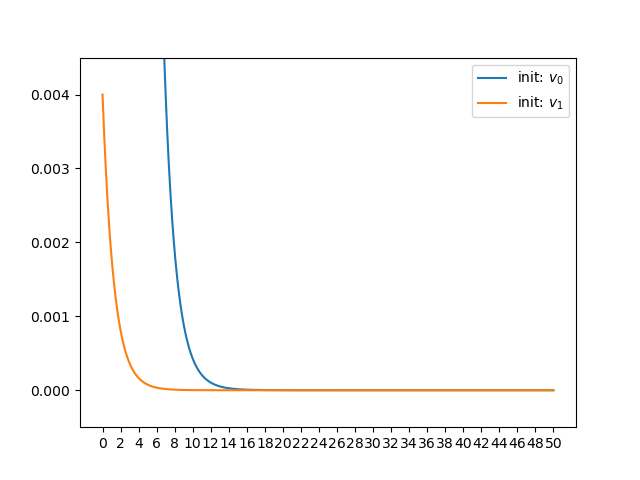

In [7]:
plt.ion()
plt.figure()

def contrib_vt(tmom, t=0):
    c = torch.full_like(tmom.ys, torch.nan)
    c[0] =  tmom(0) if t==0 else (1-tmom(0))*tmom(0)**(t-1)
    for i in range(1, len(tmom.ys)):
        c[i] = c[i-1] * tmom(i)
    return c


plt.plot(tmom.xs(0, EPOCHS), contrib_vt(tmom, 0), label=f'init: $v_0$')
plt.plot(tmom.xs(0, EPOCHS), contrib_vt(tmom, 1), label=f'init: $v_1$')
plt.xticks(torch.linspace(0, EPOCHS, EPOCHS//2 + 1))
#plt.yscale('log')
plt.ylim(-0.0005, 0.0045)
plt.legend()

### Can we change the behavoir with a different Scheduler?

torch.Size([10000])

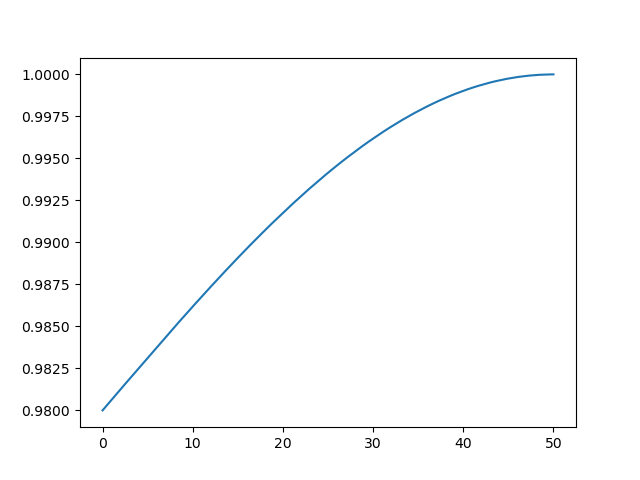

In [9]:
class HalfCosSched(Schedule):
    def __init__(self, y_start, y_end):
        super().__init__()
        self.y_start = y_start
        self.y_end = y_end

    def set_ys(self):
        cos = torch.cos(self.xs(-torch.pi/2, 0))
        self.ys = self.y_start + (self.y_end - self.y_start) * cos

plt.ion()
plt.figure()

tmom = HalfCosSched(0.98, 1.0).prep(STEPS, EPOCHS)
plt.plot(tmom.xs(0, EPOCHS), tmom.ys)
tmom.ys.shape

In [10]:
plot_distribution(tmom, EPOCHS//5 + 1, (-0.0005, 0.01))

AppLayout(children=(IntSlider(value=1, description='Iteration:', layout=Layout(grid_area='footer', margin='0px…

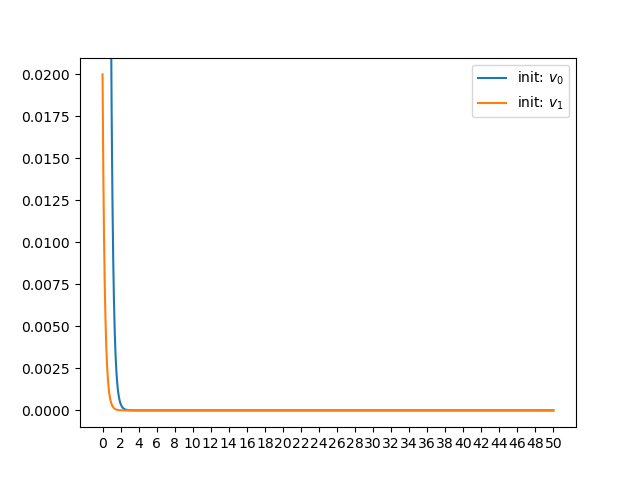

In [12]:
plt.ion()
plt.figure()

plt.plot(tmom.xs(0, EPOCHS), contrib_vt(tmom, 0), label=f'init: $v_0$')
plt.plot(tmom.xs(0, EPOCHS), contrib_vt(tmom, 1), label=f'init: $v_1$')
plt.xticks(torch.linspace(0, EPOCHS, EPOCHS//2 + 1))
#plt.yscale('log')
plt.ylim(-0.001, 0.021)
plt.legend()

### Demo of Scheduler Class

LinWarmup(0.1, 0.6, 10)


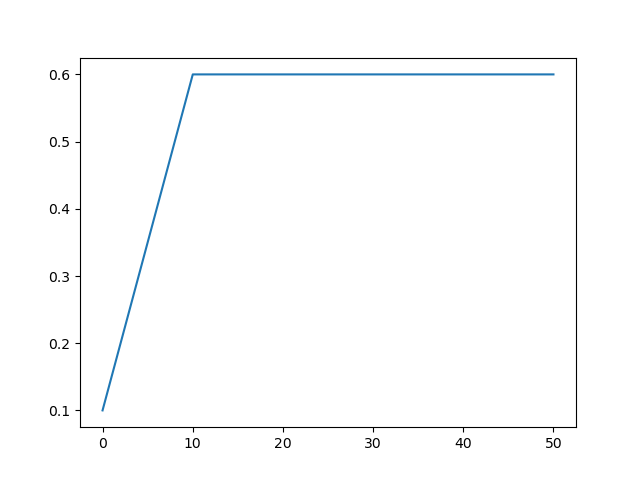

In [27]:
plt.figure()

#sched = CatSched(0.4, 0.6)
sched = Schedule.parse('LinWarmup(0.1, 0.6, 10)')

print(sched.prep(STEPS, EPOCHS))
plt.plot(sched.xs(0, EPOCHS), sched.ys)

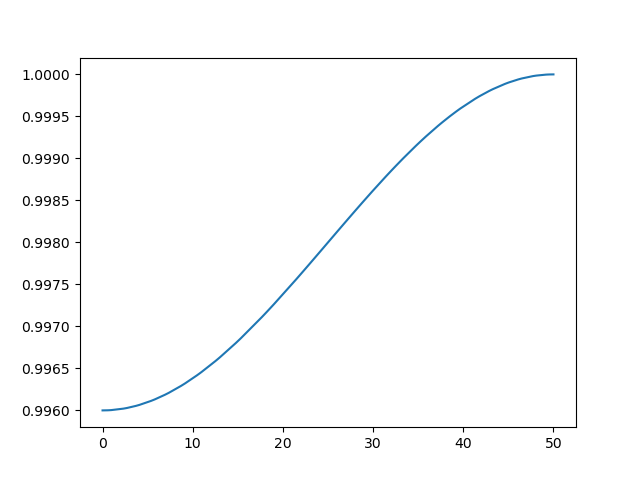

In [32]:
sched = CosSched(0.996, 1.0).prep(STEPS, EPOCHS)
steps = torch.arange(0, STEPS)
ys_iter = torch.full_like(sched.ys, torch.nan)

for i in steps:
    ys_iter[i] = sched(i)

plt.figure()
plt.plot(sched.xs(0, EPOCHS), ys_iter)